#Table of Contents
* [1. Inicialização](#1.-Inicialização)
	* [1.1 Carregar dataset](#1.1-Carregar-dataset)
	* [1.2 Tratar dataset.](#1.2-Tratar-dataset.)
* [2. Não usar variáveis de bairro: m1](#2.-Não-usar-variáveis-de-bairro:-m1)
* [3. Usar variáveis de bairro: m2](#3.-Usar-variáveis-de-bairro:-m2)
* [4. Remover bairros com poucas observações $m_{bairro}<n_{var}$: m3](#4.-Remover-bairros-com-poucas-observações-$m_{bairro}<n_{var}$:-m3)
	* [4.1 Identificar bairros com poucas observações](#4.1-Identificar-bairros-com-poucas-observações)
	* [4.2 Remover bairros com poucas observações](#4.2-Remover-bairros-com-poucas-observações)
* [5. Remover variáveis correlacionadas](#5.-Remover-variáveis-correlacionadas)
	* [5.1 Verificar correlação absoluta com preço](#5.1-Verificar-correlação-absoluta-com-preço)
	* [5.2 Identificar variáveis correlacionadas](#5.2-Identificar-variáveis-correlacionadas)
	* [5.3 Remover variávies correlacionadas de menor correlação com preço: m4](#5.3-Remover-variávies-correlacionadas-de-menor-correlação-com-preço:-m4)
	* [5.4 Remover variávies correlacionadas por quantidade de ocorrencia: m5](#5.4-Remover-variávies-correlacionadas-por-quantidade-de-ocorrencia:-m5)
* [6. Lag espacial sem bairros: m6](#6.-Lag-espacial-sem-bairros:-m6)
* [7. Lag espacial com bairros: m7](#7.-Lag-espacial-com-bairros:-m7)
* [8. Lag espacial sem variáveis correlacionadas](#8.-Lag-espacial-sem-variáveis-correlacionadas)
	* [8.1 Remover variáveis correlacionadas de menor correlação com preço: m8](#8.1-Remover-variáveis-correlacionadas-de-menor-correlação-com-preço:-m8)
	* [8.2 Remover variaveis correlacionadas por quantidade: m9](#8.2-Remover-variaveis-correlacionadas-por-quantidade:-m9)
* [9. Seleção manual: m10](#9.-Seleção-manual:-m10)
	* [9.1 Identificar variáveis correlacionadas](#9.1-Identificar-variáveis-correlacionadas)
		* [9.1.1 Acessiblidade](#9.1.1-Acessiblidade)
		* [9.1.2 Distância](#9.1.2-Distância)
		* [9.1.3 Variáveis dummies](#9.1.3-Variáveis-dummies)
	* [9.2 Executar modelo](#9.2-Executar-modelo)
	* [9.3 Tradicional: m10trad](#9.3-Tradicional:-m10trad)
		* [9.3.1 Lag Espacial: m10lag](#9.3.1-Lag-Espacial:-m10lag)
* [10. Avaliar evolução do modelo escolhido, m10, adicionando uma variável por vez](#10.-Avaliar-evolução-do-modelo-escolhido,-m10,-adicionando-uma-variável-por-vez)
* [11. Salvar resultados](#11.-Salvar-resultados)


# 1. Inicialização

In [34]:
%pylab inline
import zap_util as z
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import OrderedDict
from sklearn import cross_validation as cv
import pysal

K_FOLDS = 4
CORR_THRESHOLD = 0.8
z.set_style()
# Lista de modelos
score = []
rcParams['figure.figsize'] = (9,6)
# Variáveis a serem tratadas como categóricas.
vars_catgr = ['suites','quartos','garagem']



Populating the interactive namespace from numpy and matplotlib


In [35]:

def plot_score(scr = None, size= (6,4)):
    '''
    Plota gráfico comparativo do RMSE dos modelos.
    '''
    if scr == None: 
        scr = score
    x_name = []
    y_test = []
    y_train = []
    for name, train, test,r2 in scr:
        x_name.append(name)
        y_train.append(train)
        y_test.append(test)
    figsize(size[0],size[1])
    scatter(range(len(x_name)), y_train,color='b', label='Treino');
    scatter(range(len(x_name)), y_test,color='r', label='Teste');
    xticks(range(len(x_name)), x_name, rotation=90);
    legend();
    xlim(-1,len(x_name)+1);



    
    
def save_result(name,results):
    '''
    Helper para registro do RMSE.
    '''
    for i in range(len(score)):
        if name ==score[i][0]:
            score[i] = [name,results[0],results[1],results[2]]
            return i
    score.append([name,results[0],results[1],results[2]])





def plot_rmser2(scr = None, size= (6,4)):
    '''
    Plota um scatter plot com o RMSE no eixo X e R2 no eixo Y.
    '''

    if scr == None: 
        scr = score
    x_name = []
    x_train = []
    x_test = []
    x_r2 = []
    for name, train, test,r2 in scr:
        x_name.append(name)
        x_train.append(train)
        x_test.append(test)
        x_r2.append(1-r2)
    f,a=subplots()
    f.set_size_inches(size)
    a.scatter(x_test, x_r2,color='b');
    xlabel(r'$RMSE(Test)$',fontsize=14);
    ylabel(r'$1-R^2$',fontsize=14);
    
    for i in range(len(score)):
        label, x, y = x_name[i], x_test[i], x_r2[i]
        sinal = -1
        if i%2:
            sinal = 1

        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, 20*sinal),
            textcoords = 'offset points', 
            ha = 'right', 
            va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', 
                        fc = 'white', 
                        alpha = 0.5),
            arrowprops = dict(arrowstyle = '->',
                              connectionstyle = 'arc3,rad=0',
                              color='black')
            )
   
def to_html(lm_result,model):
    DIR = './modelos'
    z.res_coef(lm_result).\
        to_html('{}/{}_all.html'.format(DIR,model))
    z.res_coef_bairros(lm_result).\
        to_html('{}/{}_{}.html'.format(DIR,model,'bairros'))
    z.res_coef_intr(lm_result).\
        to_html('{}/{}_{}.html'.format(DIR,model,'vars'))
    lm_result.save('./modelos/{}.bin'.format(model))


## 1.1 Carregar dataset

In [36]:
# Obter dataset do Banco de Dados. 
df = z.get_imoveis_dataframe(False)

df.shape

(28111, 75)

## 1.2 Tratar dataset.

In [37]:
# Verificação de nulos.
has_null = df.isnull().sum().sum() != 0
print 'Nulos no dataset: {}'.format(has_null)

Nulos no dataset: False


In [38]:
# Verificação de constantes.
std_ = df.std()
has_const = std_[std_<0.001].sum()
print 'Variaveis constantes: {}'.format(has_const)

Variaveis constantes: 0


In [39]:
print u'Qtd de variáveis: {}'.format(df.shape[1])

Qtd de variáveis: 75


# 2. Não usar variáveis de bairro: m1

In [7]:
reload(z)
df_m1 = z.prep_statsmodels(df,False )
del df_m1['bairro_g']
df_m1.shape

(28111, 75)

In [8]:
%%time

save_result('m1', z.run_model( df_m1,K_FOLDS))


CPU times: user 3.42 s, sys: 418 ms, total: 3.83 s
Wall time: 3.19 s


In [9]:
lm,_,_ = z.ols(df_m1,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m1')
del df_m1

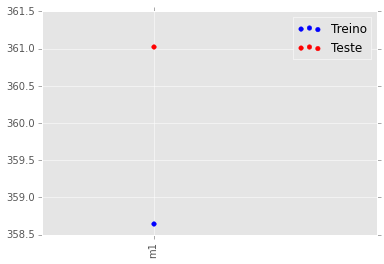

In [13]:
plot_score()

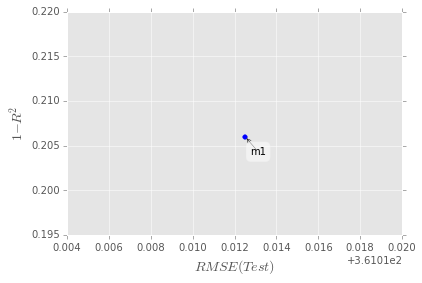

In [14]:
plot_rmser2()

# 3. Usar variáveis de bairro: m2

In [15]:
df_m2 = z.prep_statsmodels(df,True,True)
df_m2.shape

(28111, 229)

In [16]:
%%time

save_result('m2', z.run_model(df_m2,K_FOLDS))


CPU times: user 28.9 s, sys: 2.88 s, total: 31.8 s
Wall time: 24 s


In [17]:
lm,_,_ = z.ols(df_m2,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m2')
del df_m2

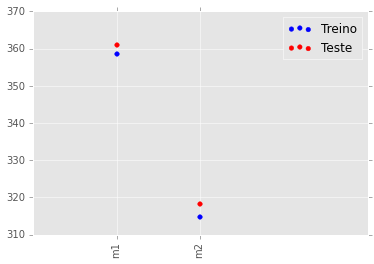

In [18]:
plot_score()

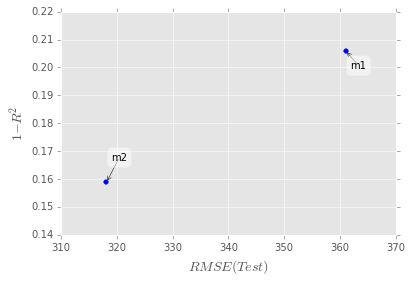

In [19]:
plot_rmser2()

# 4. Remover bairros com poucas observações $m_{bairro}<n_{var}$: m3

## 4.1 Identificar bairros com poucas observações

In [20]:
bairro = df.bairro_g.copy()
bairro = bairro.apply(lambda x : x.replace(' ', '_').\
    replace('(','').replace(')',''))

In [21]:
print 'Quantidade total de variáveis: {}'.format( df.shape[1])

Quantidade total de variáveis: 75


In [22]:
print 'Qtd total de bairros: {}'.format(len(bairro.unique()))

Qtd total de bairros: 155


In [23]:
print 'Qtd de observações: {}'.format(len(df))

Qtd de observações: 28111


In [24]:
# Bairros com menos observações que qtd de variáveis.
x = bairro.value_counts()
bairro_less = x[x<df.shape[1]]

In [25]:
print 'Qtd de bairros com poucas observações: {}'.format(len(bairro_less))

Qtd de bairros com poucas observações: 103


In [26]:
# Bairros com mais observações que qtd de variáveis.
bairro_more = x[x>df.shape[1]]

In [27]:
print 'Qtd de bairros com mais observações: {}'.format(len(bairro_more))

Qtd de bairros com mais observações: 51


## 4.2 Remover bairros com poucas observações

In [28]:
df_m3 = z.prep_statsmodels(df)

In [29]:
print 'Antes da remoção, m = {}, n = {}'.format(df_m3.shape[0], df_m3.shape[1])

Antes da remoção, m = 28111, n = 229


In [30]:
df_m3 = df_m3[~df.bairro_g.isin(bairro_less.index.tolist())].copy()
for i in bairro_less.index.tolist():
    del df_m3[i]


In [31]:
print 'Depois da remoção, m = {}, n = {}'.format(df_m3.shape[0], df_m3.shape[1])

Depois da remoção, m = 26704, n = 126


In [32]:
# Verificar variáveis constantes.
const = df_m3.columns[df_m3.std() < 0.001]
print 'Qtd de variáveis constantes: {}'.format(len(const))

Qtd de variáveis constantes: 0


In [33]:
%%time

save_result('m3', z.run_model(df_m3,K_FOLDS))


CPU times: user 7.68 s, sys: 789 ms, total: 8.46 s
Wall time: 6.63 s


In [34]:
lm,_,_ = z.ols(df_m3,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m3')
del df_m3

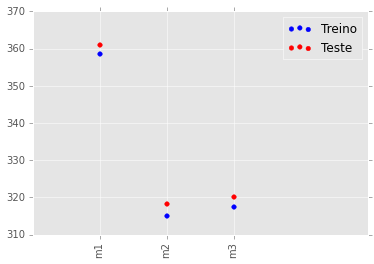

In [35]:
plot_score()

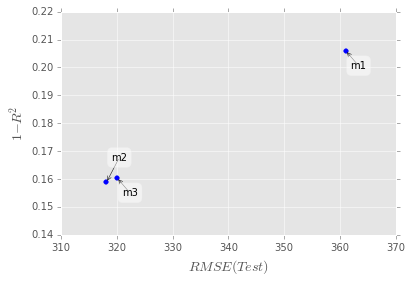

In [36]:
plot_rmser2()

# 5. Remover variáveis correlacionadas

## 5.1 Verificar correlação absoluta com preço

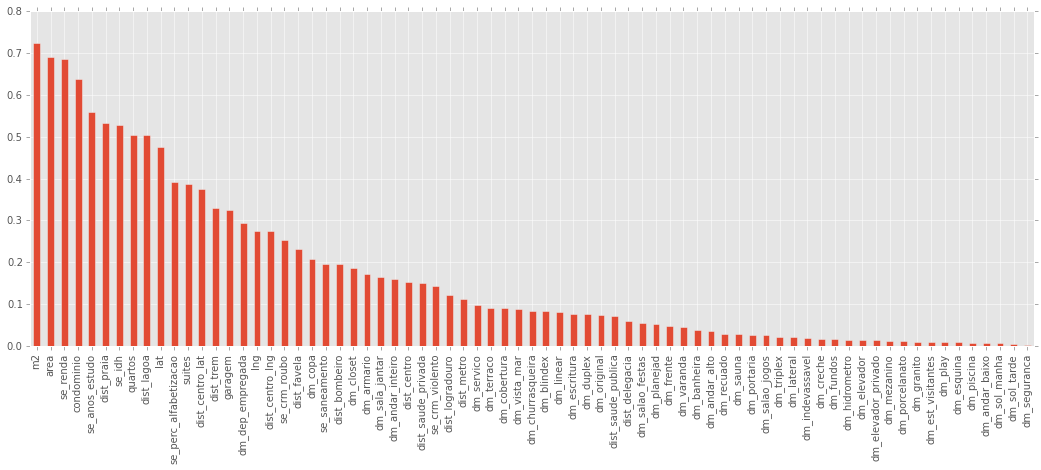

In [37]:

dcorr = {}
for var in df.columns:
    if var not in ['bairro_g','preco']:
        dcorr[var] = corrcoef(df.preco,df[var])[0][1]
dcorrabs = z.pd.Series(dcorr).abs()
dcorrabs.sort(ascending=False);
dcorrabs.plot(kind='bar', figsize=(18,6));

## 5.2 Identificar variáveis correlacionadas

In [38]:
# Identificação inicial das variáeis correlacionadas.
z.print_autocorr(df,[])

Coluna               | Autocorrelacionada com                            
se_anos_estudo       : ['se_renda(0.86)', 'se_idh(0.94)', 'se_perc_alfabetizacao(0.85)']
dist_delegacia       : ['dist_metro(0.85)']                              
dist_centro_lng      : ['lng(-1.00)', 'dist_centro(0.97)', 'dist_metro(0.89)']
se_saneamento        : ['dist_centro_lng(-0.81)', 'lng(0.81)', 'dist_metro(-0.81)']
lng                  : ['dist_centro(-0.97)', 'dist_metro(-0.89)']       
dist_centro          : ['dist_metro(0.94)']                              
se_idh               : ['se_perc_alfabetizacao(0.83)']                   
dist_trem            : ['dist_centro_lat(0.90)']                         
dist_lagoa           : ['lat(0.91)']                                     


## 5.3 Remover variávies correlacionadas de menor correlação com preço: m4

In [39]:
# Ordenar variáveis por correlação com preço.

# Dicionário de variáveis correlacionadas.
vars_ac = z.vars_corr(df.corr(), CORR_THRESHOLD)

# Transformar os valores do dict em uma lista só.
vars_coef = reduce(lambda x,y : x+y,  vars_ac.values())

# Extrair somente o nome.
vars_ = [i[:i.find('(')] for i in vars_coef] 

# Unir com demais variáveis keys do dict. 
vars_ = list(set(vars_).union(set(vars_ac.keys())))

# Recuperar correlação com preço.
vars_ac = dcorrabs[vars_]

# Ordernar por correlação com preço.
vars_ac.sort()

# Excluir variáveis temporárias.
del vars_, vars_coef

# Exibir lista final.
vars_ac


dist_delegacia           0.059389
dist_metro               0.112188
dist_centro              0.152582
se_saneamento            0.196676
dist_centro_lng          0.275108
lng                      0.276008
dist_trem                0.330050
dist_centro_lat          0.375193
se_perc_alfabetizacao    0.392501
lat                      0.475684
dist_lagoa               0.503342
se_idh                   0.527971
se_anos_estudo           0.559080
se_renda                 0.685542
dtype: float64

In [40]:
# Refinamento da correlação.
vars_auto_corr1 = ['dist_delegacia','dist_metro','dist_centro','se_saneamento',
    'dist_centro_lng','dist_trem','se_perc_alfabetizacao', 'se_anos_estudo']

z.print_autocorr(df,vars_auto_corr1,CORR_THRESHOLD)

Coluna               | Autocorrelacionada com                            
dist_lagoa           : ['lat(0.91)']                                     


In [41]:
print 'Quantidade de variáveis correlacionadas: {}'.format(len(vars_auto_corr1))

Quantidade de variáveis correlacionadas: 8


In [42]:
print 'Quantidade total de variáveis: {}'.format( len(df.columns))

Quantidade total de variáveis: 75


In [43]:
df_m4 = z.prep_statsmodels(df)

In [44]:
print 'Antes da remoção, m = {}, n = {}'.format(df_m4.shape[0], df_m4.shape[1])

Antes da remoção, m = 28111, n = 229


In [45]:
for i in vars_auto_corr1:
    try:
        del df_m4[i]
    except:
        print 'Erro ao tentar excluir {}.'.format(i)

Erro ao tentar excluir dist_centro_lng.
Erro ao tentar excluir se_anos_estudo.


In [46]:
# Verificar variáveis constantes.
const = df_m4.columns[df_m4.std() == 0]
print 'Qtd de variáveis constantes: {}'.format(len(const))

Qtd de variáveis constantes: 0


In [47]:
print 'Depois da remoção, m = {}, n = {}'.format(df_m4.shape[0], df_m4.shape[1])

Depois da remoção, m = 28111, n = 223


In [48]:
%%time

save_result('m4', z.run_model(df_m4,K_FOLDS))


CPU times: user 26.3 s, sys: 2.66 s, total: 28.9 s
Wall time: 23.2 s


In [49]:
lm,_,_ = z.ols(df_m4,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m4')
del df_m4

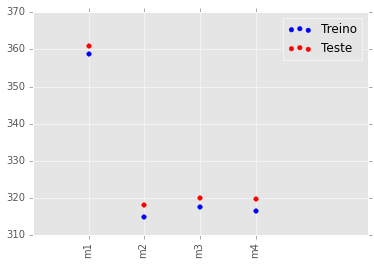

In [50]:
plot_score()

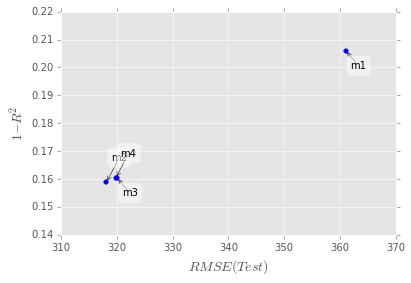

In [51]:
plot_rmser2()

## 5.4 Remover variávies correlacionadas por quantidade de ocorrencia: m5

In [52]:
# Ordenar variáveis por ocorrência.
vars_ac = z.vars_corr(df.corr(), CORR_THRESHOLD)
vars_coef = reduce(lambda x,y : x+y,  vars_ac.values())
vars_ = [i[:i.find('(')] for i in vars_coef] + vars_ac.keys()
vars_ = z.pd.Series(vars_)
vars_.value_counts()


dist_metro               5
dist_centro_lng          4
dist_centro              2
se_idh                   2
se_saneamento            2
se_perc_alfabetizacao    2
dist_lagoa               1
dist_trem                1
lng                      1
lat                      1
se_renda                 1
dist_centro_lat          1
dist_delegacia           1
se_anos_estudo           1
dtype: int64

In [53]:
# Refinamento da correlação.
vars_auto_corr2 = ['dist_metro','dist_centro_lng', 
    'se_idh','se_perc_alfabetizacao','dist_trem', 'se_anos_estudo']
vars_auto_corr2.sort()
z.print_autocorr(df,vars_auto_corr2,CORR_THRESHOLD)

Coluna               | Autocorrelacionada com                            
se_saneamento        : ['lng(0.81)']                                     
lng                  : ['dist_centro(-0.97)']                            
dist_lagoa           : ['lat(0.91)']                                     


In [54]:
print 'Quantidade de variáveis correlacionadas: {}'.format(len(vars_auto_corr2))

Quantidade de variáveis correlacionadas: 6


In [55]:
print 'Quantidade total de variáveis: {}'.format( len(df.columns))

Quantidade total de variáveis: 75


In [56]:
df_m5 = z.prep_statsmodels(df)


In [57]:
print 'Antes da remoção, m = {}, n = {}'.format(df_m5.shape[0], df_m5.shape[1])

Antes da remoção, m = 28111, n = 229


In [58]:
for i in vars_auto_corr2:
    try:
        del df_m5[i]
    except:
        print 'Erro ao tentar excluir variavel {}.'.format(i)


Erro ao tentar excluir variavel dist_centro_lng.
Erro ao tentar excluir variavel se_anos_estudo.


In [59]:
# Verificar variáveis constantes.
const = df_m5.columns[df_m5.std() == 0]
print 'Qtd de variáveis constantes: {}'.format(len(const))

Qtd de variáveis constantes: 0


In [60]:
print 'Depois da remoção, m = {}, n = {}'.format(df_m5.shape[0], df_m5.shape[1])

Depois da remoção, m = 28111, n = 225


In [61]:
%%time

save_result('m5', z.run_model(df_m5,K_FOLDS))


CPU times: user 23.7 s, sys: 2.32 s, total: 26 s
Wall time: 19.6 s


In [62]:
lm,_,_ = z.ols(df_m5,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m5')
del df_m5

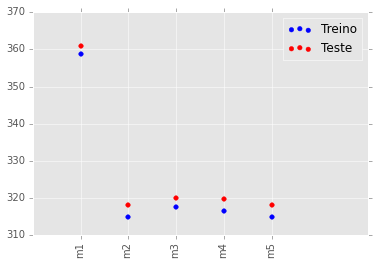

In [63]:
plot_score()

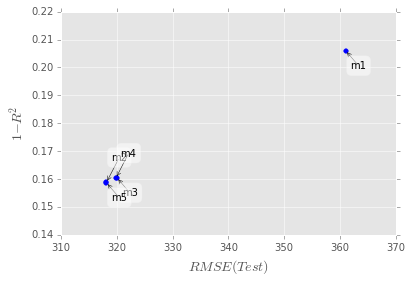

In [64]:
plot_rmser2()

# 6. Lag espacial sem bairros: m6

In [65]:
w = z.getW()

In [66]:
df_m6 = z.prep_statsmodels(df, False)
del df_m6['bairro_g']
df_m6['preco_lag'] = pysal.lag_spatial(w, df_m6.preco)

In [67]:
df_m6.shape

(28111, 76)

In [68]:
%%time
save_result('m6', z.run_model(df_m6,K_FOLDS))


CPU times: user 4.07 s, sys: 595 ms, total: 4.67 s
Wall time: 3.89 s


In [69]:
lm,_,_ = z.ols(df_m6,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m6')
del df_m6

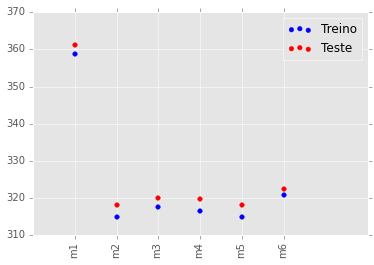

In [70]:
plot_score()

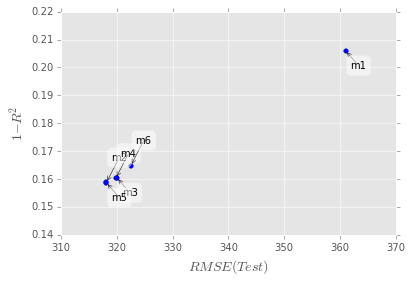

In [71]:
plot_rmser2()

# 7. Lag espacial com bairros: m7

In [72]:
df_m7 = z.prep_statsmodels(df)
df_m7.shape

(28111, 229)

In [73]:
%%time
save_result('m7', z.run_model(df_m7, K_FOLDS))

CPU times: user 33.5 s, sys: 3.9 s, total: 37.4 s
Wall time: 31.2 s


In [74]:
lm,_,_ = z.ols(df_m7,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m7')
del df_m7

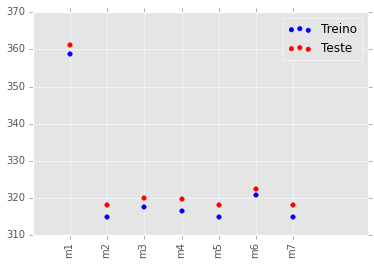

In [75]:
plot_score()

(0.155, 0.165)

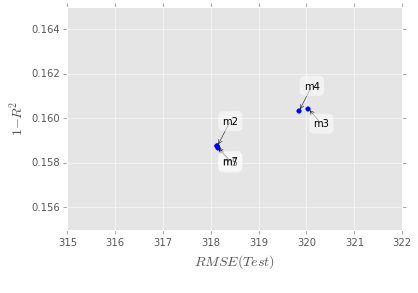

In [76]:
plot_rmser2()
xlim(315,322)
ylim(0.155,0.165)

# 8. Lag espacial sem variáveis correlacionadas

## 8.1 Remover variáveis correlacionadas de menor correlação com preço: m8

In [77]:
df_m8 = z.prep_statsmodels(df)

In [78]:
df_m8 = z.prep_statsmodels(df)
for i in vars_auto_corr1:
    try:
        del df_m8[i]
    except:
        print 'Erro ao tentar excluir {}.'.format(i)
df_m8.shape

Erro ao tentar excluir dist_centro_lng.
Erro ao tentar excluir se_anos_estudo.


(28111, 223)

In [79]:
# Verificar se tem constantes
std_ = df_m8.std()
std_[std_<0.001]

Series([], dtype: float64)

In [80]:
%%time

save_result('m8', z.run_model(df_m8,K_FOLDS))


CPU times: user 23.1 s, sys: 2.16 s, total: 25.3 s
Wall time: 18.8 s


In [81]:
lm,_,_ = z.ols(df_m8,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m8')
del df_m8

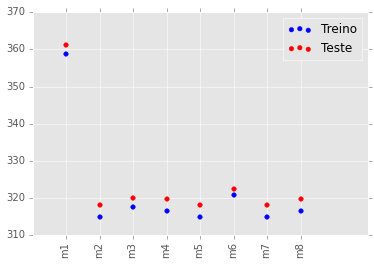

In [82]:
plot_score()

(315, 325)

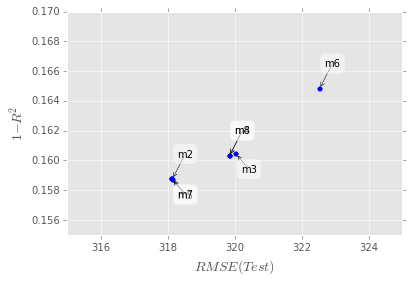

In [83]:
plot_rmser2()
ylim(0.155,0.17)
xlim(315,325)

## 8.2 Remover variaveis correlacionadas por quantidade: m9

In [84]:
df_m9 = z.prep_statsmodels(df)

In [85]:
df_m9 = z.prep_statsmodels(df)
for i in vars_auto_corr1:
    try:
        del df_m9[i]
    except:
        print 'Erro ao tentar excluir {}.'.format(i)
df_m9.shape

Erro ao tentar excluir dist_centro_lng.
Erro ao tentar excluir se_anos_estudo.


(28111, 223)

In [86]:
# Verificar se tem constantes
std_ = df_m9.std()
std_[std_<0.001]

Series([], dtype: float64)

In [87]:
%%time
save_result('m9', z.run_model(df_m9,K_FOLDS))

CPU times: user 26.2 s, sys: 2.88 s, total: 29.1 s
Wall time: 22.9 s


In [88]:
lm,_,_ = z.ols(df_m9,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m9')
del df_m9

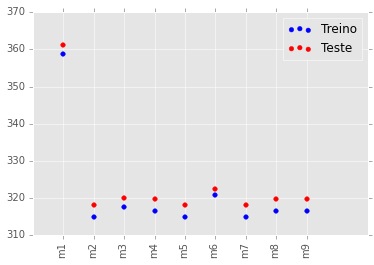

In [89]:
plot_score()

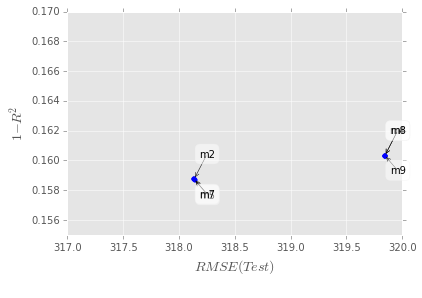

In [90]:
plot_rmser2()
xlim(317,320);
ylim(0.155,0.17);

# 9. Seleção manual: m10

## 9.1 Identificar variáveis correlacionadas

### 9.1.1 Acessiblidade

In [40]:
vars_se = [i for i in df.columns if i.find('se_') > -1]
df_se = df[vars_se]
corr_se = df_se.corr()
z.print_autocorr(corr_se)

Coluna               | Autocorrelacionada com                            
se_crm_violento      : ['se_perc_alfabetizacao(-0.88)', 'se_renda(-0.88)', 'se_idh(-0.88)']
se_renda             : ['se_idh(0.95)', 'se_crm_roubo(-0.95)']           
se_anos_estudo       : ['se_crm_violento(-0.90)', 'se_perc_alfabetizacao(0.96)', 'se_renda(0.97)', 'se_idh(0.99)', 'se_crm_roubo(-0.95)']
se_idh               : ['se_crm_roubo(-0.94)']                           
se_perc_alfabetizacao : ['se_renda(0.89)', 'se_idh(0.97)', 'se_crm_roubo(-0.86)']


In [41]:
vars_ig_se = ['se_renda', 'se_perc_alfabetizacao','se_anos_estudo',
              'se_crm_violento','se_crm_roubo','se_saneamento']
z.print_autocorr(corr_se, vars_ig_se)

Nao ha colunas correlacionadas entre si.


In [42]:
del vars_se,df_se,corr_se

### 9.1.2 Distância

In [43]:
vars_dist = [i for i in df.columns if i.find('dist_') > -1]
df_dist = df[vars_dist]
corr_dist = df_dist.corr()
z.print_autocorr(corr_dist)

Coluna               | Autocorrelacionada com                            
dist_saude_publica   : ['dist_centro_lat(0.80)', 'dist_trem(0.87)', 'dist_lagoa(-0.87)']
dist_bombeiro        : ['dist_centro_lng(0.81)', 'dist_centro(0.82)']    
dist_delegacia       : ['dist_centro(0.91)', 'dist_metro(0.97)', 'dist_centro_lat(0.81)', 'dist_trem(0.89)']
dist_centro_lng      : ['dist_centro(0.96)', 'dist_metro(0.87)']         
dist_praia           : ['dist_centro_lat(-0.91)', 'dist_trem(-0.84)', 'dist_lagoa(0.84)']
dist_centro          : ['dist_metro(0.97)']                              
dist_metro           : ['dist_trem(0.84)']                               
dist_centro_lat      : ['dist_trem(0.98)', 'dist_lagoa(-0.90)']          
dist_trem            : ['dist_lagoa(-0.94)']                             


In [44]:
vars_ig_dist = ['dist_centro_lat','dist_centro_lng','dist_saude_publica',
         'dist_bombeiro','dist_delegacia','dist_trem','dist_lagoa','dist_metro']

z.print_autocorr(corr_dist,vars_ig_dist)

Nao ha colunas correlacionadas entre si.


In [45]:
del vars_dist,df_dist,corr_dist

### 9.1.3 Variáveis dummies

In [46]:
vars_dm = [i for i in df.columns if i.find('dm_')>-1]

In [47]:
df_dm = df[vars_dm]
z.print_autocorr(df_dm.corr())

Coluna               | Autocorrelacionada com                            
dm_churrasqueira     : ['dm_sauna(0.89)']                                
dm_salao_jogos       : ['dm_churrasqueira(0.81)', 'dm_est_visitantes(0.85)', 'dm_sauna(0.85)']
dm_banheira          : ['dm_creche(0.87)', 'dm_est_visitantes(0.83)']    
dm_creche            : ['dm_est_visitantes(0.88)']                       
dm_duplex            : ['dm_cobertura(0.80)']                            
dm_piscina           : ['dm_salao_festas(0.85)', 'dm_salao_jogos(0.84)', 'dm_play(0.81)', 'dm_churrasqueira(0.94)', 'dm_sauna(0.95)']
dm_play              : ['dm_churrasqueira(0.81)', 'dm_sauna(0.82)']      
dm_salao_festas      : ['dm_play(0.95)', 'dm_churrasqueira(0.85)', 'dm_sauna(0.85)']


In [48]:
vars_ig_dm = ['dm_churrasqueira','dm_duplex','dm_salao_jogos','dm_est_visitantes',
        'dm_salao_festas','dm_banheira','dm_sauna','dm_play']

z.print_autocorr(df_dm.corr(), vars_ig_dm)

Nao ha colunas correlacionadas entre si.


In [49]:
del vars_dm,df_dm

## 9.2 Executar modelo

In [65]:
df_m10 = z.prep_statsmodels(df, False)
del df_m10['bairro_g']

In [66]:
vars_ig = vars_ig_se+vars_ig_dm+vars_ig_dist

In [67]:
z.print_autocorr(df_m10, vars_ig)

Nao ha colunas correlacionadas entre si.


In [68]:
for i in vars_ig:
    try:
        del df_m10[i]
    except Exception:
        print 'Variavel {} nao existe no modelo.'.format(i)
df_m10.shape

Variavel se_anos_estudo nao existe no modelo.
Variavel dist_centro_lat nao existe no modelo.
Variavel dist_centro_lng nao existe no modelo.


(28111, 56)

## 9.3 Tradicional: m10trad

In [54]:
%%time
save_result('m10trad', z.run_model(df_m10, K_FOLDS))

CPU times: user 2.73 s, sys: 426 ms, total: 3.16 s
Wall time: 2.73 s


In [55]:
lm,_,_ = z.ols(df_m10,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m10trad')


### 9.3.1 Lag Espacial: m10lag

In [69]:
w = z.getW()
df_m10['preco_lag'] = pysal.lag_spatial(w,df_m10.preco)

In [ ]:
%%time
save_result('m10lag', z.run_model(df_m10, K_FOLDS))

In [ ]:
lm,_,_ = z.ols(df_m10,avoid_plow=True, remove_plow_by_step=True)
to_html(lm,'m10lag')
del df_m10

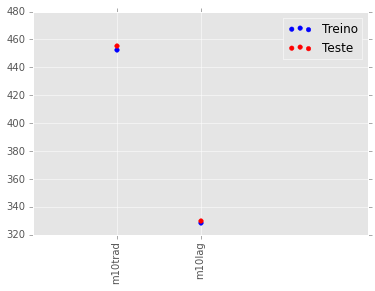

In [59]:
plot_score()

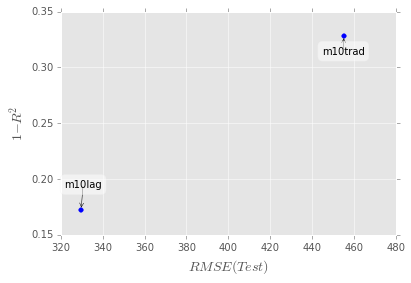

In [60]:
plot_rmser2()

(315, 325)

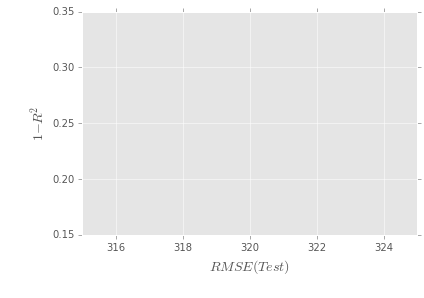

In [61]:
plot_rmser2()
xlim(315,325)

# Testes da última regressão

http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/regression_diagnostics.html

## Normalidade dos resíduos

In [79]:

import itertools
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(lm.resid)
lzip(name, test)

[('Jarque-Bera', 105065.0729196179),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.4530117089764092),
 ('Kurtosis', 12.01416704647791)]

# Heteroscedasticidade
Teste de Breusch-Pagan

Baseado no teste multiplicador de Lagrange, o teste de Breusch-Pagan é bastante utilizado para testar a hipótese nula de que as variâncias dos erros são iguais (homoscedasticidade) versus a hipótese alternativa de que as variâncias dos erros são uma função multiplicativa de uma ou mais variáveis, sendo que esta(s) variável(eis) pode(m) pertencer ou não ao modelo em questão.

In [81]:
# Há evidências de que as variâncias não são iguais
# Ho é rejeitada se p-value < 0.05
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4581.9736603426018),
 ('p-value', 0.0),
 ('f-value', 143.85944847815045),
 ('f p-value', 0.0)]

In [83]:
# Testa homoscedasticidade
# The null hypothesis for the GQ test is homoskedasticity. 
# Não há evidências de que pode-se rejeitar Ho.
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
lzip(name, test)

[('F statistic', 0.92481965421553003), ('p-value', 0.99999813470199517)]

# Verificar com somente variáveis básicas

In [23]:
z.pd.DataFrame.from_csv('./modelo_selecionado/score_lm.csv')

,rmse_train,rmse_test,r2
model,,,
m1,358.640252,361.022507,0.794023
m2,314.862875,318.136192,0.841249
m3,317.539812,320.040699,0.839577
m4,316.420277,319.845501,0.839675
m5,314.791103,318.141165,0.841321
m6,320.835695,322.535652,0.835172
m7,314.862875,318.136192,0.841249
m8,316.420277,319.845501,0.839675
m9,316.420277,319.845501,0.839675


In [15]:
df11 = df[['preco','area','garagem','quartos','suites']]
z.run_model(df11, K_FOLDS)

(569.30129697117252, 569.47456588070713, 0.48100513055342009)

In [18]:
w = z.getW()
df11_lag = df11.copy()
df11_lag['preco_lag'] = pysal.lag_spatial(w,df11_lag.preco)
z.run_model(df11_lag, K_FOLDS)

(343.96371305754047, 344.00730527150915, 0.81055362624773919)

In [32]:
reload(z)
df12_lag = df11_lag.copy()
df12_lag = z.prep_statsmodels(df12_lag, False)
z.run_model(df12_lag, K_FOLDS)

(340.31692082451514, 340.64463831942675, 0.81454860910956439)

# 10. Avaliar evolução do modelo escolhido, m10, adicionando uma variável por vez

In [114]:
%%time 
import re
import IPython


if False:


    score_vars = []
    cols = []
    for var_ in dcorrabs.index.tolist():
        if var_ in df_m10.columns.tolist():
            cols.append(var_)
            dfx = df_m10[['preco']+cols]
            print 'Modelo com {} variaveis.  Ultima: {}'.\
                format(dfx.shape[1]-1,var_)
            lm,_,_ = z.ols(dfx, [],[],False, True)
            score_vars.append(['n_{}'.format(i), z.rmse(lm.resid), 
                              lm.rsquared, dfx.shape[1]-1])
    
    
    IPython.display.clear_output()    

    score_vars = array(score_vars);
    x_name = score_vars[:,0];
    y_rmse = score_vars[:,1];
    f,a = subplots();
    f.set_size_inches(12,6);
    a.scatter(range(len(cols)),y_rmse);
    xticks(range(len(cols)),cols, rotation=90);
    xlim(-1,len(cols));
    ylabel('RMSE')

    savefig('../texto/img/vars_evolucao_rmse.png');    
    z.pd.DataFrame(score_vars , 
        columns=['model','rmse_train','rmse_test']).\
        to_csv('./modelo_selecionado/score_variaveis.csv', index=False)



CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 13.1 µs


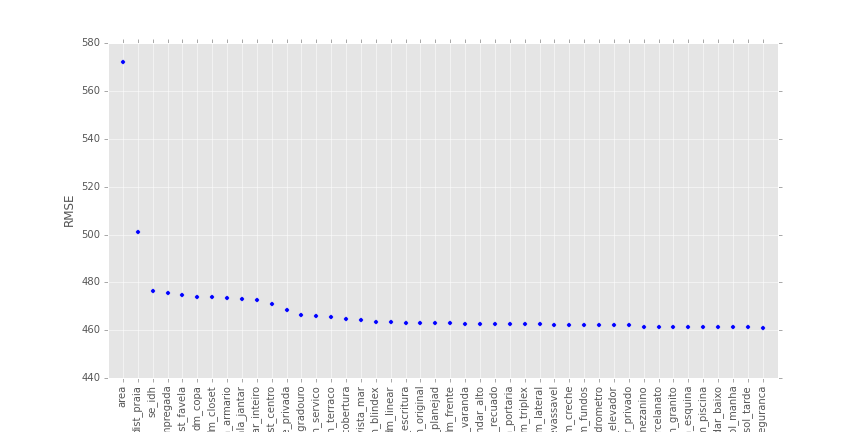

In [115]:
IPython.display.Image(filename='../texto/img/vars_evolucao_rmse.png')

# 11. Salvar resultados

In [116]:
z.pd.DataFrame(score , 
    columns=['model','rmse_train','rmse_test','r2']).\
    to_csv('./modelo_selecionado/score_lm.csv', index=False)


In [117]:
# Copia arquivos
!cp ./modelos/m10lag.bin ./modelo_selecionado/
!cp ./modelos/m10trad.bin ./modelo_selecionado/